## Data Pre-processing

#### Import relevant modules

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix

#### Load the dataset

In [0]:
#Read csv file into dataframe
df = pd.read_csv("https://raw.githubusercontent.com/biyanoscar/Assignment5-DPS4/master/weatherAUS.csv")

In [4]:
#Show the first 7 rows
df.head(7) 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0.0,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,0.0,No


In [5]:
#Show descriptive statistics
df.describe(include='all')

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
count,142193,142193,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132863,132923.000000,132180,138415,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,140787,142193.000000,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2
top,2014-01-11,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,No
freq,49,3418,NaN,NaN,NaN,NaN,NaN,9780,NaN,11393,10663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109332,NaN,110316
mean,NaN,NaN,12.186400,23.226784,2.349974,5.469824,7.624853,NaN,39.984292,NaN,NaN,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,NaN,2.360682,NaN
std,NaN,NaN,6.403283,7.117618,8.465173,4.188537,3.781525,NaN,13.588801,NaN,NaN,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,NaN,8.477969,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,NaN,0.000000,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.900000,NaN,31.000000,NaN,NaN,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,NaN,0.000000,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.500000,NaN,39.000000,NaN,NaN,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,NaN,0.000000,NaN
75%,NaN,NaN,16.800000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,NaN,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,NaN,0.800000,NaN


In [6]:
#Show for each column how many null values
df.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [7]:
#Remove missing values and show tuple representing the dimensionality of the DataFrame
df.dropna(inplace = True) 
df.shape

(56420, 24)

In [0]:
# Drop Date, Location, Evaporation, Sunshine, Cloud3pm, Cloud9am, and RISK_MM from DataFrame because of we hypothesis it as unneeded value
df.drop(labels = ['Date','Location','Evaporation','Sunshine','Cloud3pm','Cloud9am','RISK_MM'],axis = 1,inplace = True)

In [0]:
# Replace Nilai Yes / No
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [0]:
# Convert 'WindGustDir','WindDir9am','WindDir3pm' variable into indicator variables.
categorical = ['WindGustDir','WindDir9am','WindDir3pm']
df_final = pd.get_dummies(df,columns = categorical,drop_first=True)

In [11]:
# Show the first 5 rows
df_final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
5939,17.9,35.2,0.0,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,26.6,33.4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5940,18.4,28.9,0.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,20.3,27.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5942,19.4,37.6,0.0,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,28.7,34.9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5943,21.9,38.4,0.0,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,29.1,35.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5944,24.2,41.0,0.0,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,33.6,37.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [12]:
# Show a comparison between the RainTomorrow count and length of DataFrame
df_final['RainTomorrow'].value_counts()/len(df_final)

0    0.779741
1    0.220259
Name: RainTomorrow, dtype: float64

## Separating Your Training and Testing Datasets

In [0]:
X = df_final.drop(['RainTomorrow'],axis=1).values
y = df_final['RainTomorrow'].values

In [0]:
X1, X_test, y1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#validation set to evaluate results from the training set
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=42)

## Transforming the Data

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Define the plotting function

In [16]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


## Artificial Neural Network

#### Define a deep neural net model

In [0]:
def create_model(my_learning_rate):
    output_size = 1
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(11, kernel_initializer = "uniform",activation = "relu",name='Hidden1'))# 1st hidden layer
    
    # Define the output layer. sigmoid activation
    model.add(tf.keras.layers.Dense(output_size, kernel_initializer = "uniform",activation = "sigmoid")) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="binary_crossentropy", 
                metrics=["accuracy"])
    
    return model

#### Define a training function

In [0]:
def train_model(model, features_arr, label_arr,validation_inputs, validation_targets, epochs, 
                batch_size=None):
    # set an early stopping mechanism
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

    history = model.fit(features_arr, label_arr, batch_size, epochs, 
                          callbacks=[early_stopping], # early stopping
                          validation_data=(validation_inputs, validation_targets), # validation data
                          verbose = 2 # making sure we get enough information about the training process
                       )
    
    # To track the progression of training, gather a snapshot
    # of the model's metrics at each epoch. 
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist

#### Call the functions to build and train a deep neural net

Epoch 1/35
121/121 - 0s - loss: 0.4436 - accuracy: 0.8153 - val_loss: 154.6736 - val_accuracy: 0.7751
Epoch 2/35
121/121 - 0s - loss: 0.3457 - accuracy: 0.8516 - val_loss: 137.3717 - val_accuracy: 0.7751
Epoch 3/35
121/121 - 0s - loss: 0.3377 - accuracy: 0.8546 - val_loss: 107.2078 - val_accuracy: 0.7751
Epoch 4/35
121/121 - 0s - loss: 0.3333 - accuracy: 0.8568 - val_loss: 96.1330 - val_accuracy: 0.7751
Epoch 5/35
121/121 - 0s - loss: 0.3298 - accuracy: 0.8583 - val_loss: 98.0734 - val_accuracy: 0.7751
Epoch 6/35
121/121 - 0s - loss: 0.3264 - accuracy: 0.8603 - val_loss: 95.6020 - val_accuracy: 0.7751
Epoch 7/35
121/121 - 0s - loss: 0.3232 - accuracy: 0.8620 - val_loss: 68.7011 - val_accuracy: 0.7751
Epoch 8/35
121/121 - 0s - loss: 0.3221 - accuracy: 0.8614 - val_loss: 66.9647 - val_accuracy: 0.7751
Epoch 9/35
121/121 - 0s - loss: 0.3196 - accuracy: 0.8633 - val_loss: 44.3051 - val_accuracy: 0.7751
Epoch 10/35
121/121 - 0s - loss: 0.3187 - accuracy: 0.8634 - val_loss: 58.4241 - val_acc

[0.3384408950805664, 0.8536866307258606]

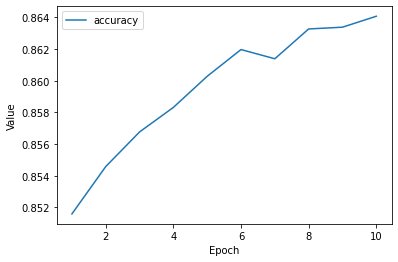

In [19]:
# The following variables are the hyperparameters.
learning_rate = 0.002
epochs = 35
batch_size = 300

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model
epochs, hist = train_model(my_model, X_train, y_train,X_val, y_val, epochs, 
                          batch_size)
# plot_the_loss_curve(epochs, mse)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = X_test, y = y_test, batch_size=batch_size)

## Running Predictions on the Test Set

In [20]:
y_pred = my_model.predict(X_test)
y_train_pred = my_model.predict_classes(X_train)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [21]:
print('Training Accuracy ---->',accuracy_score(y_train,y_train_pred))
print('Testing Accuracy  ---->',accuracy_score(y_test,y_pred.round()))

Training Accuracy ----> 0.8665115763819652
Testing Accuracy  ----> 0.8536866359447005


In [22]:
confusion_matrix(y_test,y_pred.round(), labels=[1, 0])

array([[1342, 1143],
       [ 508, 8291]])